### Week 05


In [99]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

np.random.seed(42)

# Universal Bank Promotional Campaign: A practical illustration of *model performance assessment using confusion matrices*


## Problem Statement

Universal Bank has begun a program to encourage existing customers to borrow via a consumer loan program. 

The bank has tested a loan promotion on a random sample of 5000 customers. This test promotion resulted in 480 of the 5000 existing customers accepting the offer. 

The bank is intrigued by the success of this promotion. It has hired you to help them develop a model to identify which of its remaining customers may accept a similar promotion. 

They hired you to help them reduce the promotion costs and target the offer to only a subset of its customers that or more likely to accept the offer. They disclosed that the cost to promote this offer is \\$10 dollars per customer, and the profit from obtaining a loan customer is \\$100. They have an additional 50,000 customers that have not been contacted about the promotion. 

## Preliminary business problem scoping

Before starting your analysis, you jot down what the profit and loss (P&L) must have been from their marking trial. Since they targeted every customer, they only have FP and TP.

In [100]:
TP_profit = 100 - 10   # the sale profit minus the targeting cost
TN_profit = 10 # they wouldn't take a loan, and we didn't spend the money targeting them
FP_profit = -10   # no loan profit, just the targeting cost
FN_profit = -100+10  # they would have taken the loan, but we didn't target them 

# in the null model there are only FP's and TP's because everyone is considered a possible customer
original_profit = 480*TP_profit + (5000-480)*FP_profit
print(f"${original_profit:,.2f}")

$-2,000.00


Using this approach on the remaining 50000 customers would not be a good business decision, as it would result in a loss of...

In [101]:
print(f"${original_profit*50000/5000:,.2f}")

$-20,000.00


Based on this initial analysis, it's clear that the bank cannot continue this promotion unless they have a model to help them identify the best potential customers. The best model possible would be 100% accurate. Universal Bank's initial test resulted in 480 or 5000 customers choosing to take the offer. The rate 480/5000 is, therefore, the expected rate of customers that take the request, and thus the expected profit result from a perfectly accurate model would be:

In [102]:
print(f"${(480*TP_profit+(5000-480)*TN_profit)*10:,.2f}")

$884,000.00


> **Universal Bank is making the right decision in bringing you in to help them. You're probably now thinking you should renegotiate your constulting fee :)**

## Load, Explore and Clean Data

In [103]:
# Load the data direct from GitHub
df = pd.read_csv('https://raw.githubusercontent.com/prof-tcsmith/data/master/UniversalBank.csv') 
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Check column names, and for convenience, remove whitespaces...

In [104]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

Here I aim to remove whitespaces and insert underscore

In [105]:
df.columns = [s.strip().upper().replace(' ', '_') for s in df.columns] 
df.columns

Index(['ID', 'AGE', 'EXPERIENCE', 'INCOME', 'ZIP_CODE', 'FAMILY', 'CCAVG',
       'EDUCATION', 'MORTGAGE', 'PERSONAL_LOAN', 'SECURITIES_ACCOUNT',
       'CD_ACCOUNT', 'ONLINE', 'CREDITCARD'],
      dtype='object')

We decide that a couple of variables aren't predictors; therefore we drop them and then check if there are any missing values in the remaining variables...

In [106]:
# drop ID, and Zip Code as predictors
df = df.drop(columns=['ID', 'ZIP_CODE'])

# check for missing values
df.isnull().sum()

AGE                   0
EXPERIENCE            0
INCOME                0
FAMILY                0
CCAVG                 0
EDUCATION             0
MORTGAGE              0
PERSONAL_LOAN         0
SECURITIES_ACCOUNT    0
CD_ACCOUNT            0
ONLINE                0
CREDITCARD            0
dtype: int64

Check the variable types

In [107]:
df.dtypes

AGE                     int64
EXPERIENCE              int64
INCOME                  int64
FAMILY                  int64
CCAVG                 float64
EDUCATION               int64
MORTGAGE                int64
PERSONAL_LOAN           int64
SECURITIES_ACCOUNT      int64
CD_ACCOUNT              int64
ONLINE                  int64
CREDITCARD              int64
dtype: object

In [108]:
df.SECURITIES_ACCOUNT.unique()

array([1, 0], dtype=int64)

In [109]:
df.CD_ACCOUNT.unique()

array([0, 1], dtype=int64)

In [110]:
df.ONLINE.unique()

array([0, 1], dtype=int64)

In [111]:
df.CREDITCARD.unique()

array([0, 1], dtype=int64)

In [112]:
df.PERSONAL_LOAN.unique()

array([0, 1], dtype=int64)

In [113]:
df.EDUCATION.unique()

array([1, 2, 3], dtype=int64)

In [114]:
df = pd.get_dummies(
    df, 
    prefix_sep='_', 
    dummy_na=False, 
    drop_first=True, 
    columns=['EDUCATION'], 
    dtype='int8'
)

In [115]:
df.describe()

,AGE,EXPERIENCE,INCOME,FAMILY,CCAVG,MORTGAGE,PERSONAL_LOAN,SECURITIES_ACCOUNT,CD_ACCOUNT,ONLINE,CREDITCARD,EDUCATION_2,EDUCATION_3
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,2.396400,1.937938,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000,0.280600,0.300200
std,11.463166,11.467954,46.033729,1.147663,1.747659,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637,0.449337,0.458391
min,23.000000,-3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,1.000000,0.700000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,2.000000,1.500000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
75%,55.000000,30.000000,98.000000,3.000000,2.500000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000
max,67.000000,43.000000,224.000000,4.000000,10.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


## Split and Normalize Data

K-nn models are sensitive to differences in scale; therefore, we should begin by eliminating any differences in scale between the predictors/features. To accomplish this, we will standardize the values of each variable.

We will use the popular sklearn library's 'standard scaler' to accomplish this. This library contains many of the common functions we require when conducting analytics. The standard scaler function will standardize our variables. To achieve this, we will first need to train the scaler on the training data and then apply this trained scaler to standardize both the training and validation sets. 

In [116]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

features = df.drop(columns=['PERSONAL_LOAN'])
target = df['PERSONAL_LOAN']

# split the data into validation and training set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

# create a standard scaler and fit it to the training set of predictors
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Transform the predictors of training and validation sets
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

> * https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
> * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Let's now explore the results of the standardization (NOTE: The returned object from a scaler transform is a numpy array)

## Train a K-NN model

You've heard that a good starting point in determining a k value is to try the square root of the total observations. Since there are 5000 observations, following this rule of thumb, we would select a k value of 70  (but it's best to choose an odd number so that we will use k=71).

> If k is an even number, there is a possibility that an observation could have the same number of nearest neighbors being one class (they took the loan) as the number being another (did not take the loan). In the cases of a tie, the SKLearn implementation of k-nn will select the first found. Though the chances of this happening are low, it's better to avoid this by choosing an odd number.

In [117]:
model = KNeighborsClassifier(n_neighbors=71,  metric='euclidean') # user euclidean distance

# We could choose other distance metrics; for a list of other metrics...
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics
# coverage of difference distance metrics is outside of this courses scope... but, you can experiment by changing the metric
# for example...
#knn = KNeighborsClassifier(n_neighbors=71,  metric='manhattan')

model.fit(X_train, y_train)

results = pd.DataFrame()
results['actual'] = y_test
results['predicted'] = model.predict(X_test)
results.head(20)

,actual,predicted
2764,0,0
4767,0,0
3814,0,0
3499,0,0
2735,0,0
3922,0,0
2701,0,0
1179,0,0
932,0,0
792,0,0


> * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
> * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric


In [118]:
df['PERSONAL_LOAN'].value_counts()  

0    4520
1     480
Name: PERSONAL_LOAN, dtype: int64

In [119]:
df['PERSONAL_LOAN'].value_counts()[1] / (df['PERSONAL_LOAN'].value_counts()[1] + df['PERSONAL_LOAN'].value_counts()[0])

0.096

In [120]:
results['predicted'].value_counts()  

0    1469
1      31
Name: predicted, dtype: int64

In [121]:
results['predicted'].value_counts()[1] / (results['predicted'].value_counts()[1] + results['predicted'].value_counts()[0])

0.020666666666666667

> Note that we know that the TP rate is 480/5000 = 9.% in the sample, but our predictions have a TP rate of 2.7%. This is a bit of a 'red flag' to indicate that the precision of our model may be poor - which is most likely due to the imbalance between classes in our training data (480 in one class and 4520 in the other). Such imbalances can be a problem with many machine learning algorithms, including k-nn. Addressing this problem is a topic for another class, but the influence of the unbalanced data can be partially mitigated by using a smaller k value. We will see this in practice when we cover hyper-parameter tuning in the next class.

> For now, we will ignore this potential opportunity to improve our model and move ahead with our analysis to see if this model is sufficient to help Universal Bank generate profit. 

## Measure performance of model using confusion matrix

In [122]:
confusion = confusion_matrix(results['actual'], results['predicted'])   

> * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [123]:
confusion

array([[1350,    1],
       [ 119,   30]], dtype=int64)

In [124]:
TP = confusion[1, 1] # True Positives
TN = confusion[0, 0] # True Negatives
FP = confusion[0, 1] # False Positives
FN = confusion[1, 0] # False Negatives

### Here the values for the confusion matrix are as follows:
### True positve = 30
### True Negative = 1350
### False Positive = 1
### False Negative = 119

### Accuracy:

How often was the model correct?

In [125]:
classification_accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"{classification_accuracy:.4f}")

0.9200


### Misclassification Rate:

How often was the model incorrect?

In [126]:
classification_error = (FP + FN) / (TP + TN + FP + FN)
# this is the same as ...
# classification_error = 1-classification_accuracy

print(f"{classification_error:.4f}")

0.0800


### Precision: 

When a positive value is predicted, how often is the prediction correct?

In other wordes: How "precise" is the classifier when predicting positive instances?

In [127]:
precision = TP / (TP + FP)
print(f"{precision:.4f}")

0.9677


### Recall (aka sensititivy):

Ability of a classification model to identify all relevant instances. 
Also referred to as Sensitivity, Probability of Detection, True Positive Rate


In [128]:
recall = TP / (TP + FN)
print(f"{recall:.4f}")

0.2013


### F1 Score

This is a measure that takes the harmonic mean of precision and recall.

In [129]:
f1_Score = (2 * precision * recall) / (precision + recall)
print(f"{f1_Score:.4f}")

0.3333


* As the analytics consultant, you know what all the above performance measures mean - but while presenting this information to the CEO, she became impatient and interrupted you to ask how profit and loss will be impacted if they choose to use this model over simply targeting everyone (you then take a note to yourself to place more focus on profit and loss when speaking with future CEO's)*

Let's look at how we could address this question...

## Is our k-nn model a better model that the null (promote to all) model?


Based on your initial business problem scoping, you calculated Universal Bank's expected profit from targeting the remaining 50,000 customers without the support of a model was \\$-20,000.00. 

Let's calculate how much our model improves things...

### What would be the expected returns from not using a model?

From the initial trial, 480 of the 5000 (9.6%) customers targeted took the loan, and 5000-480 (90.4%) didn't take the loan. Since the initial test was on a random selection of customers and did not use a model, then the expected percentage of the 50000 customer will also be 9.6% and 90.4%.

In [130]:
print(f"The expected total from from null model is ${0.096 * 50_000 * TP_profit + 0.904 * 50_000 * FP_profit:0,.2f}")

The expected total from from null model is $-20,000.00


### What would the expected returns from using our model?

Let's look at the confusion matrix of the performance of the model on the test data.

In [131]:
confusion 

array([[1350,    1],
       [ 119,   30]], dtype=int64)

Let's convert these values into percentages

In [132]:
confusion_perc = confusion/(.3 * 5_000)  # since the confusion matrix is for the performance on the test data. Test set is .30% of 5000, or 1500. 
print(confusion_perc)
confusion_perc.sum() # this should add to one, if not, something is wrong

[[9.00000000e-01 6.66666667e-04]
 [7.93333333e-02 2.00000000e-02]]


1.0

Now, let's do a scaler multiplication of the number of customers that will be targetted in the newly proposed campaign (50,000 customers). This will give us the number of expected customers in each of the categories in the confusion matrix (TP, FP, TN, FN)

In [133]:
knn_result = confusion_perc * 50_000
knn_result

array([[4.50000000e+04, 3.33333333e+01],
       [3.96666667e+03, 1.00000000e+03]])

Now, let's create a p_and_l matrix (profit and loss)

In [134]:
p_and_l = np.array([[TN_profit, FP_profit],[FN_profit, TP_profit]])
p_and_l

array([[ 10, -10],
       [-90,  90]])

Multiple our profit and loss matrix with our knn_result matrix to get profit and loss associated with each of the catgories (FP, TP, FN, TN)

In [135]:
knn_result * p_and_l

array([[ 4.50000000e+05, -3.33333333e+02],
       [-3.57000000e+05,  9.00000000e+04]])

To get the total profit, we simply need to sum up all the p_and_l's for each category (TP, FP, TN, FN)

In [136]:
model_profit = (knn_result * p_and_l).sum()

print(f"${model_profit:,.2f}")

$182,666.67


As we can see, using a k value of 71 is not a very good value for k. At a loss of 236,000.00; this is much worse than the null model (where they simply don't use a model and target every customer) which was a loss of $20,000.

## Testing other values of k


Let us explore the performance of our model.

Notice that though accuracy looks quite good, recall is relatively poor. Since the cost of an FN is very high (loss of \$100) relative to the cost of a false positive (a loss of \$10), the distribution of the misclassified observations between FP and FN is significant. Any errors we must accept are much more advantageous if these are FP's. 

As we noted in the early stages of this evaluation (see note in "Train a K-NN model" section), our dataset is significantly unbalanced, with the number of customers not taking a loan nearly 10x higher than those that would take a loan. K-NN is particularly sensitive to this; in this case, the more significant proportion of observations where the customer did not take a loan makes it difficult for K-NN to identify the instances where they would take a loan. (since it is much more probable that a neighbor is a non-customer, and thus, the voting will skew towards selecting an observation as a non-customer). This problem gets worse as the value of k increases. 

Is all lost?

We can make the model better. Due to the unbalanced nature of this dataset, we will likely find that the model will perform better with a lower value of k. 

Let us test this hypothesis by trying a range of k values:

In [137]:
profits = []
for i in range(1,141,2):
    knn = KNeighborsClassifier(n_neighbors=i,  metric='euclidean')
    knn.fit(X_train, y_train)
    confusion = confusion_matrix(y_test, knn.predict(X_test))
    confusion = confusion * 50_000 / confusion.sum()  # scaling this up to sample size of 50,000
    TP = confusion[1, 1] 
    TN = confusion[0, 0] 
    FP = confusion[0, 1] 
    FN = confusion[1, 0]
    profit_and_loss = np.array([[TN_profit, FP_profit],[FN_profit, TP_profit]])
    model_profit = (confusion * profit_and_loss).sum()
    profits.append(model_profit)
    print(f"For k={i} model profit is ${model_profit:,.2f}")
print("*"*80)    
print(f"Max profit is {max(profits):,.2f}")
print("*"*80)    


For k=1 model profit is $588,666.67
For k=3 model profit is $532,666.67
For k=5 model profit is $504,000.00
For k=7 model profit is $482,000.00
For k=9 model profit is $452,666.67
For k=11 model profit is $404,666.67
For k=13 model profit is $368,000.00
For k=15 model profit is $350,000.00
For k=17 model profit is $356,000.00
For k=19 model profit is $362,000.00
For k=21 model profit is $331,333.33
For k=23 model profit is $331,333.33
For k=25 model profit is $307,333.33
For k=27 model profit is $301,333.33
For k=29 model profit is $296,000.00
For k=31 model profit is $290,666.67
For k=33 model profit is $290,666.67
For k=35 model profit is $272,666.67
For k=37 model profit is $260,666.67
For k=39 model profit is $260,666.67
For k=41 model profit is $266,666.67
For k=43 model profit is $260,666.67
For k=45 model profit is $248,666.67
For k=47 model profit is $248,666.67
For k=49 model profit is $242,666.67
For k=51 model profit is $242,666.67
For k=53 model profit is $236,666.67
For k=

## Business Impact Summary

Universal Bank's initial promotional campaign offered 5,000 existing customers a loan product. Of the 5,000 targeted, 480 accepted the offer. Since the cost of targeting a customer is \$10, and the profit from getting a customer to take the loan is \$100, this initial trial resulted in a loss of \$2,000. If Universal Bank continued to use this 'null model' approach on the remaining 50,000 customers, this would result in a loss of \$20,000. 

Using a k-nn model with k=1, the expected total profit is $582,000, but a k value this low will result in a model that is likely to overfit the training data and have a high variance on future predictions. 

Based on the expected performance of the proposed model, Universal Bank could proceed with implementing a profitable campaign. However, the data shows a significant imbalance, as more customers should have taken the offer. If we reduce the negative effect of the unbalanced data set, we can develop a better-performing model. (as a reminder, a 'perfect' model would produce a profit of $884,000.00; though we cannot expect a perfect model to be found, there is room for improvement).

Also note that the best k value found is 1. This is not a good value for k, as it will result in a model that is likely to overfit and have a high variance on future predictions. Considering this, a much more stable prediction can be made with k=71 - which results in a profit of $182,666.67. We could argue that k should be lower, but we would need to consider the trade-off between variance and bias (something that will be discussed more later in the course). 

### Implementation of SVC Model

In [138]:
# Initializing the model with a linear kernel
clf_Linear = SVC(kernel='linear')
# Training the model
clf_Linear.fit(X_train, y_train)
# Making predictions
y_pred_Linear = clf_Linear.predict(X_test)

In [139]:
# Measuring Accuracy
accuracy_Linear = accuracy_score(y_test, y_pred_Linear)
# Application of the Confusion Matrix
conf_matrix_Linear = confusion_matrix(y_test, y_pred_Linear)
# Establishing Classification Report
class_report_Linear = classification_report(y_test, y_pred_Linear)

print(f'Kernel (Linear) - Accuracy: \n{accuracy_Linear}')
print(f'Kernel (Linear) - Confusion Matrix: \n{conf_matrix_Linear}')
print(f'Kernel (Linear) - Classification Report: \n{class_report_Linear}')

Kernel (Linear) - Accuracy: 
0.958
Kernel (Linear) - Confusion Matrix: 
[[1345    6]
 [  57   92]]
Kernel (Linear) - Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1351
           1       0.94      0.62      0.74       149

    accuracy                           0.96      1500
   macro avg       0.95      0.81      0.86      1500
weighted avg       0.96      0.96      0.95      1500



### 95.8% accuracy has been shown using the SVC model, indicating the proprotion of correctly predicted instances from the total instances. When the data are broken down by class, class 0 has a precision score of 0.96 which indicates that the high proportion of true negatives vs the predicted negatives and a flawless recall score of 1.0 indicating higher proportion of true negatives correctly recognized, resulting in a remarkable F1-score of 0.98 which indicates a well-balanced structure between precision and recall. Class 1 has a precision score of 0.94 indicating that the high proportion of true positves vs predicted positives, and a recall score that is somewhat lower at 0.62 indicating that the poportion is moderate for true positives correctly recognized, giving it an F1-score of 0.74 indicating acceptable balance between scores of precision and recall. To Summarise, this model performs well, as the results shows that the scores of accuracy, precision, recall, and F1-score. This model has got a high accuracy which is good in order to predict class 0 as the scores of precision and recall are high. But, this model has got a lower recall score for class 1.

### Implementation of Decision Tree Model

In [140]:
clf_DecisionTree = DecisionTreeClassifier(random_state = 42)
clf_DecisionTree.fit(X_train, y_train)
# Making predictions
y_pred_DecisionTree = clf_DecisionTree.predict(X_test)

In [141]:
# Measuring Accuracy
accuracy_DecisionTree = accuracy_score(y_test, y_pred_DecisionTree)
# Application of the Confusion Matrix
conf_matrix_DecisionTree = confusion_matrix(y_test, y_pred_DecisionTree)
# Establishing Classification Report
class_report_DecisionTree = classification_report(y_test, y_pred_DecisionTree)

print(f'Kernel (DecisionTree) - Accuracy: \n{accuracy_DecisionTree}')
print(f'Kernel (DecisionTree) - Confusion Matrix: \n{conf_matrix_DecisionTree}')
print(f'Kernel (DecisionTree) - Classification Report: \n{class_report_DecisionTree}')

Kernel (DecisionTree) - Accuracy: 
0.9826666666666667
Kernel (DecisionTree) - Confusion Matrix: 
[[1343    8]
 [  18  131]]
Kernel (DecisionTree) - Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1351
           1       0.94      0.88      0.91       149

    accuracy                           0.98      1500
   macro avg       0.96      0.94      0.95      1500
weighted avg       0.98      0.98      0.98      1500



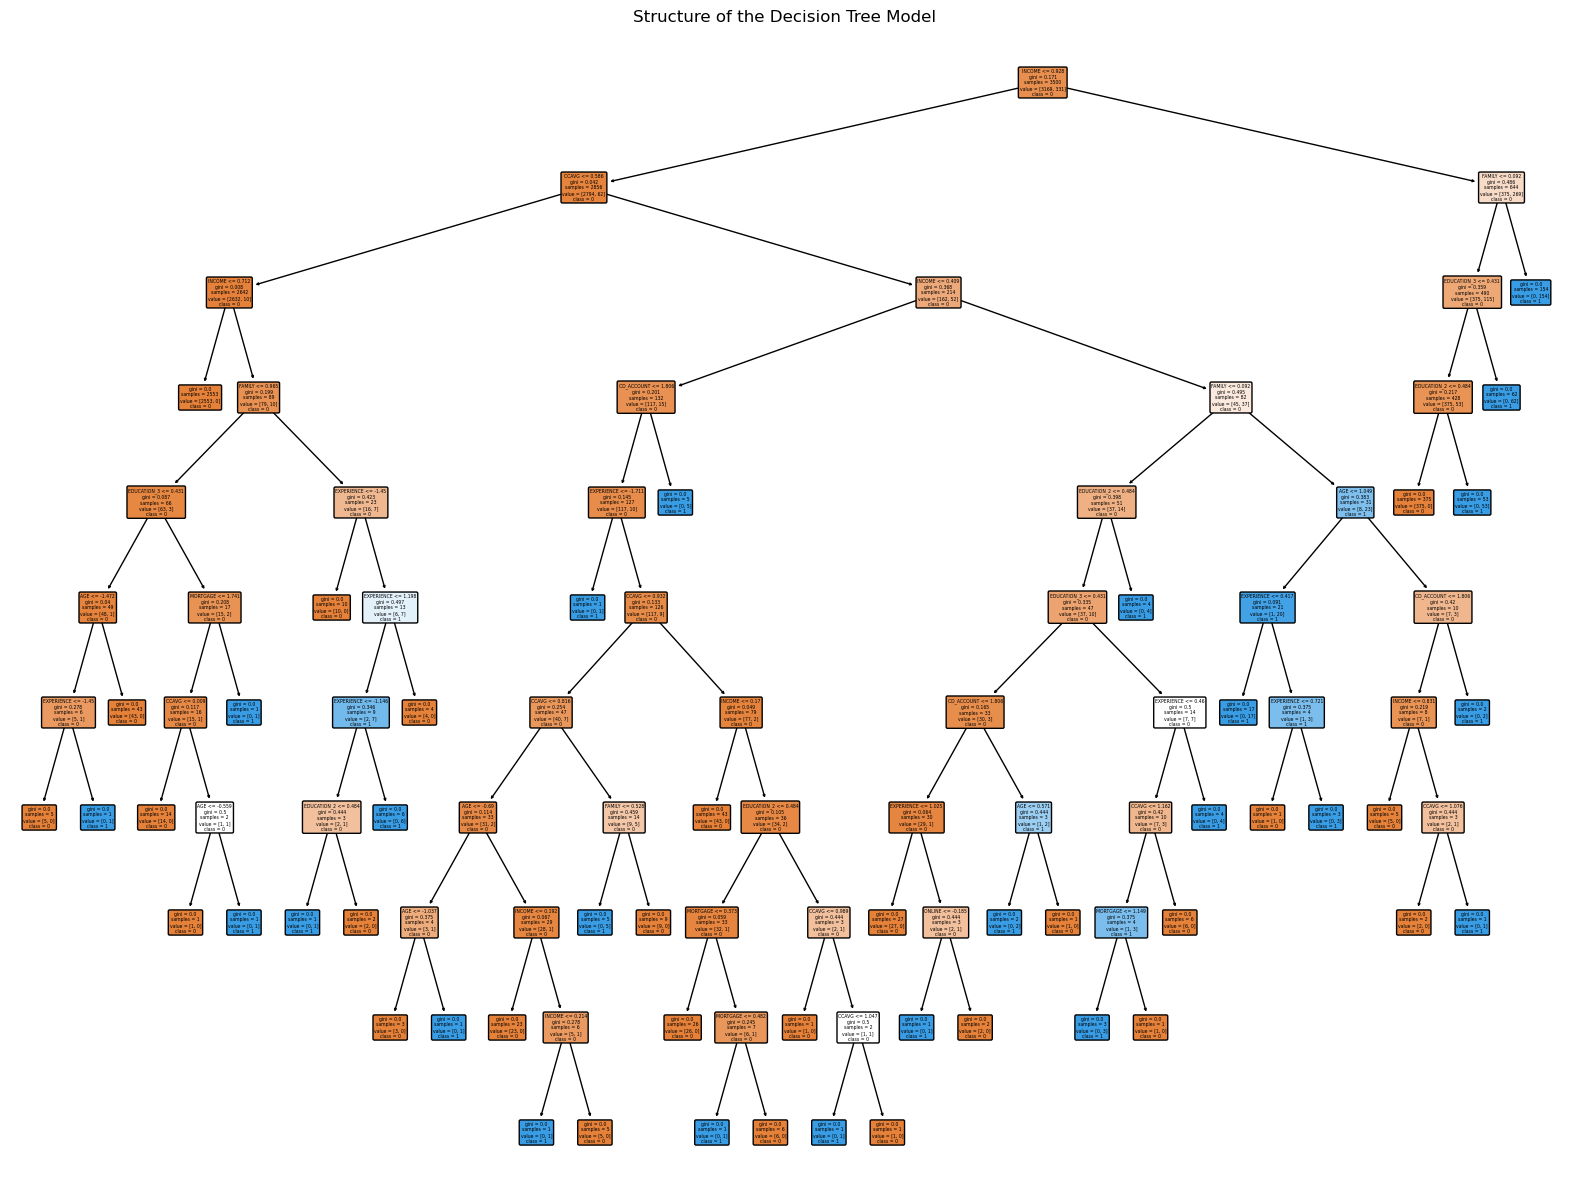

In [142]:
from sklearn.tree import plot_tree

# Plotting the Structure of the Decision Tree Model
plt.figure(figsize=(20, 15))
plot_tree(clf_DecisionTree, filled=True, feature_names=list(features.columns), class_names=["0", "1"], rounded=True)
plt.title('Structure of the Decision Tree Model')
plt.show()

### 98.27% accuracy has been shown using the Decision Tree Model, indicating the proportion of correctly predicted instances from the total instances. When the data are broken down by class, class 0 has an precision score of 0.99 which indicates that the high proportion of true negatives among negatives(predicted), a recall score of 0.99 indicates that the high proportion of true negatives that are correctly recognised, and an F1-score of 0.99 indicates that the well-balance between precision and recall for class 0. Class 1 has a precision score of 0.94, indicates that the high proportion of true positives among predicted positives, a recall score that is at 0.88 indicates that the lower proportion of true positives correctly recognized, giving it an F1 score of 0.91 indicates that the well-balance between precision and recall for the class 1. Overall, this model performed better as the scores of accuracy, precision, recall, and F1-score with both classes that is class 0 and class 1. When it comes to Class 0 this model performed very well as the results show high precision, recall, and F1-score. But for Class 1, the results show that it has got slightly lower precision score and lower recall score for class 1, it still perfromed in a decent manner on a overall sense.


### Observations:

### Here, it can be understood that, in the SVC model do have the better precision score and recall score of class 0. When it comes to Class 1, its recall score is lower. While observing the results of Decision Tree Classifier Model, it shows to perform better on both the Classes that is Class 1 and Class 2 regarding precision score, recall score and f-1 score. Higher accuracy could be accomplished with the application of Decision Tree Clasiffier Model. To conclude, I would opt for Decision Tree Classifier Model, as the results of this model shows that it has the higher accuracy score, it is also delivering the well-balanced between precision scores, recall scores for both the classes. This model also yields a lower rate of false positives when compared to the SVC Model. 